In [9]:
import matplotlib.patches as patches
import matplotlib.colors as mcolors
import matplotlib.animation as ma
import matplotlib.pyplot as plt
from matplotlib.patheffects import withStroke
from matplotlib.cm import ScalarMappable
from matplotlib import gridspec
from tqdm.notebook import tqdm
from itertools import product
import pandas as pd
import numpy as np
import numba as nb
import imageio
import pickle
import json
import os
import shutil
import sys
sys.path.append("..")

from main import *

randomSeed = 100

%matplotlib inline
%config InlineBackend.figure_format = "retina"

new_cmap = mcolors.LinearSegmentedColormap.from_list(
    "new", plt.cm.hsv(np.linspace(0, 1, 256)) * 0.85, N=256
)

@nb.njit
def colors_idx(phaseTheta):
    return np.floor(256 - phaseTheta / (2 * np.pi) * 256).astype(np.int32)

with open("../swarmalatorlib/hex_colors.json", "r", encoding="utf-8") as f:
    hexColors = json.load(f)
hexCmap = mcolors.LinearSegmentedColormap.from_list("cmap", hexColors)


import seaborn as sns

sns.set_theme(
    style="ticks", 
    font_scale=1.1, rc={
    'figure.figsize': (6, 5),
    'axes.facecolor': 'white',
    'figure.facecolor': 'white',
    'grid.color': '#dddddd',
    'grid.linewidth': 0.5,
    "lines.linewidth": 1.5,
    'text.color': '#000000',
    'figure.titleweight': "bold",
    'xtick.color': '#000000',
    'ytick.color': '#000000'
})

plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'
#plt.rcParams['animation.ffmpeg_path'] = "/opt/conda/bin/ffmpeg"

from multiprocessing import Pool
import pandas as pd

colors = ["#403990", "#3A76D6", "#FFC001", "#F46F43", "#C70000FF"]
cmap = mcolors.LinearSegmentedColormap.from_list("cmap", colors)
cmap_r = mcolors.LinearSegmentedColormap.from_list("my_colormap", colors[::-1])

colors = ["#403990", "#80A6E2", "#F46F43", "#CF3D3E"]
cmap2 = mcolors.LinearSegmentedColormap.from_list("cmap2", colors)

# SAVE_PATH = r"F:\MS_ExperimentData\general"
# MP4_PATH = r"F:\MS_ExperimentData\mp4"

SAVE_PATH = r"D:\MS_ExperimentData\general"
MP4_PATH = r"D:\MS_ExperimentData\mp4"

# LOCAL_FIG_PATH = "./PCT_C_figs"
LOCAL_FIG_PATH = "./figs"


In [10]:
distanceD0 = 0.4
deltaOmega = 0
phaseLagA0 = 0.6 * np.pi
overWrite = False

model = PhaseLagPatternFormation(
    strengthK=24, distanceD0=distanceD0, 
    phaseLagA0=phaseLagA0, boundaryLength=7, speedV=3,
    freqDist="uniform", initPhaseTheta=None,
    omegaMin=0, deltaOmega=deltaOmega, 
    agentsNum=5000, dt=0.005,
    tqdm=True, savePath=SAVE_PATH, shotsnaps=10, 
    randomSeed=10, overWrite=overWrite
)
model.run(10000)

100%|█████████████████████████████████████████████████████████| 10000/10000 [39:44<00:00,  4.19it/s]


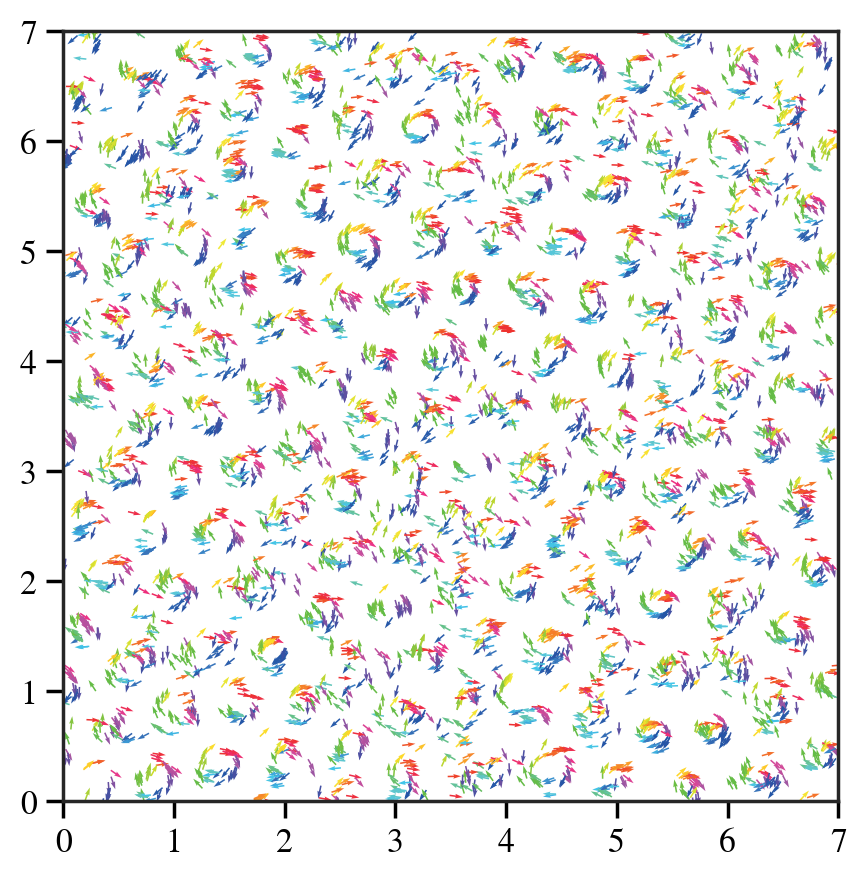

In [11]:
sa = StateAnalysis(model)
sa.plot_spatial()

In [12]:
centers = np.array([
    sa.calc_rotation_center(lookIdx=i)
    for i in tqdm(range(sa.TNum))
])
with open("temp/domin_centers.pkl", "wb") as f:
    pickle.dump(centers, f)

  0%|          | 0/1002 [00:00<?, ?it/s]

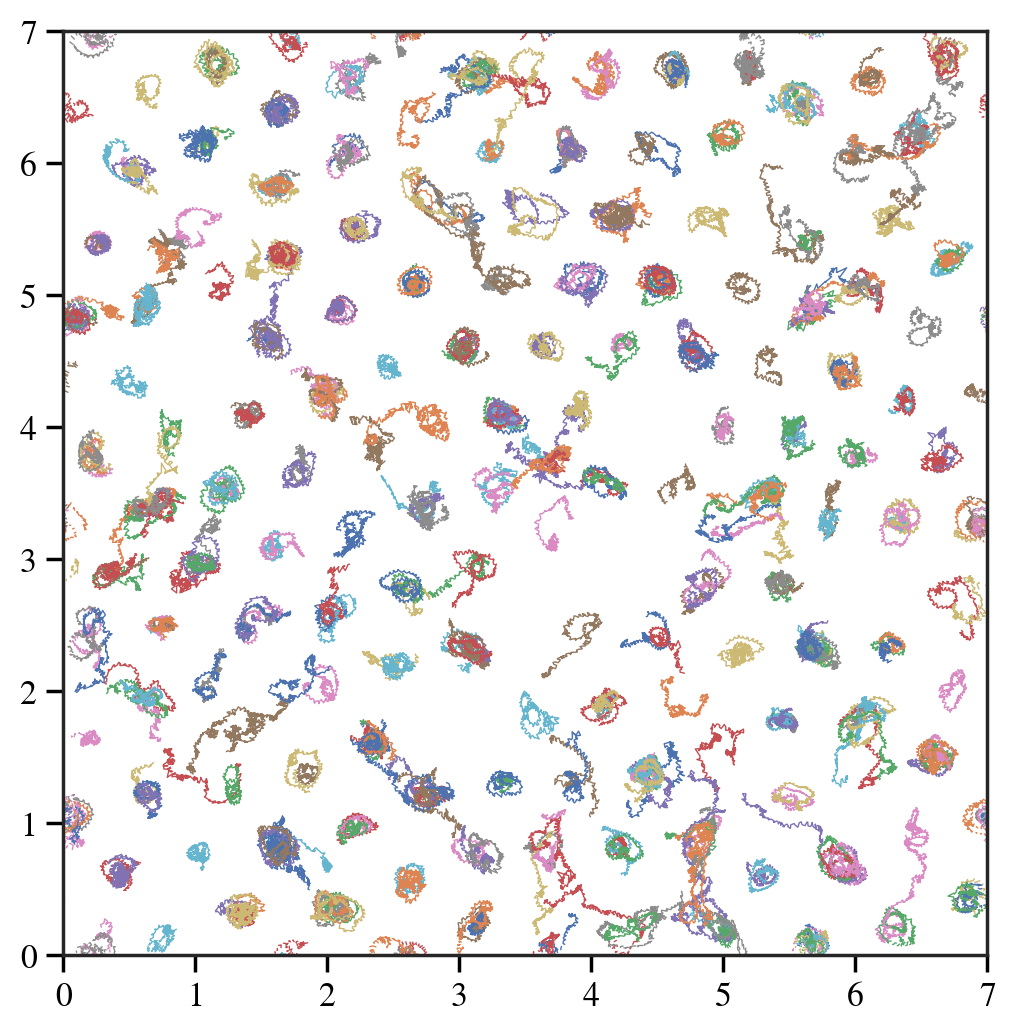

In [ ]:
with open("temp/domin_centers.pkl", "rb") as f:
    centers = pickle.load(f)

fig, ax = plt.subplots(figsize=(6, 6))
tailCounts = 500
L = model.boundaryLength
selectCounts = int(centers.shape[1] * 0.1)

for idx in range(selectCounts):
    trajectories = centers[:, idx]
    
    x = trajectories[-tailCounts:, 0]
    y = trajectories[-tailCounts:, 1]
    
    dx = np.diff(x)
    dy = np.diff(y)
    
    jump_idx = np.where((np.abs(dx) > L/4) | (np.abs(dy) > L/4))[0] + 1
    
    if len(jump_idx) > 0:
        segments = np.split(np.arange(len(x)), jump_idx)
        for seg in segments:
            if len(seg) > 1:
                ax.plot(x[seg], y[seg], lw=0.5, color=f'C{idx}')
    else:
        ax.plot(x, y, lw=0.5, color=f'C{idx}')

ax.set_xlim(0, L)
ax.set_ylim(0, L)
ax.set_aspect('equal')
plt.show()

In [ ]:
randomSeed = 10
phaseLags = [0.6 * np.pi]
strengthKs = np.linspace(1, 39, 37)
distanceD0s = [0.1]  # 0.1
omegaMins = [0]
deltaOmegas = [0]

models = [
    PhaseLagPatternFormation(
        strengthK=strengthK, distanceD0=distanceD0, phaseLagA0=phaseLag,
        boundaryLength=7, speedV=3,
        freqDist="uniform", initPhaseTheta=None,
        omegaMin=omegaMin, deltaOmega=deltaOmega, 
        agentsNum=5000, 
        dt=0.005,
        tqdm=True, savePath=SAVE_PATH, shotsnaps=10, 
        randomSeed=randomSeed, overWrite=False
    )
    for strengthK in strengthKs
    for distanceD0 in distanceD0s
    for omegaMin in omegaMins
    for deltaOmega in deltaOmegas
    for phaseLag in phaseLags
]

lastStateSavePath = r"F:\MS_ExperimentData\hyperuniform"
savePath = (
    f"{lastStateSavePath}/{models[0].__class__.__name__}_"
    f"{models[0].freqDist}_"
    f"omegaMin{models[0].omegaMin:.3f}_deltaOmega{models[0].deltaOmega:.3f}_"
    f"phaseLagA0{models[0].phaseLagA0:.3f}_"
    f"Ks{strengthKs[0]:.3f}-{strengthKs[-1]:.3f}-{len(strengthKs)}_"
    f"D0s{distanceD0s[0]:.3f}-{distanceD0s[-1]:.3f}-{len(distanceD0s)}_"
    f"bL{models[0].boundaryLength}_"
    f"lastState.h5"
)
modelsNum = len(models)

sas = list()
allPositionX = pd.read_hdf(savePath, key="positionX")
allPhaseTheta = pd.read_hdf(savePath, key="phaseTheta")
allPositionX = allPositionX.values.reshape(modelsNum, models[0].agentsNum, 2)
allPhaseTheta = allPhaseTheta.values.reshape(modelsNum, models[0].agentsNum)

for i, model in enumerate(models):
    sa = StateAnalysis()
    sa.model = model
    sa.totalPositionX = np.array([allPositionX[i]])
    sa.totalPhaseTheta = np.array([allPhaseTheta[i]])
    sas.append(sa)

positions = dict()
targetL = model.boundaryLength * 1
for sa in sas:
    model = sa.model
    positions[(model.strengthK, model.distanceD0)] = sa.totalPositionX[-1:] / model.boundaryLength * targetL
    # positions[(model.strengthK, model.distanceD0)] = sa.totalPositionX[-500:][::100] / model.boundaryLength * targetL

In [ ]:
@nb.njit
def calculate_Sq_continuous(pos: np.ndarray, q_vec: np.ndarray, N: int):
    exp = np.exp(1j * np.dot(pos, q_vec))
    # return np.abs(np.sum(exp)) / N
    return np.abs(np.sum(exp)**2 / N)


x = np.arange(1, 80) * 2 * np.pi / targetL
X, Y = np.meshgrid(x, x)
qVecs = np.column_stack((X.ravel(), Y.ravel())) # Wavevectors
q = np.linalg.norm(qVecs, axis=1)
qVecs = qVecs[np.argsort(q)]
q = np.sort(q)
qMin = 2 * np.pi * np.sqrt(2) / targetL

Sqs_dict = dict()
for params, subPositions in tqdm(positions.items()):
    
    Sqs = []
    qs = []

    for position in subPositions:
        for q_vec in qVecs:    
            Sq = calculate_Sq_continuous(position, q_vec, len(position))
            qs.append(np.linalg.norm(q_vec))
            Sqs.append(Sq)

    qs = np.array(qs)
    Sqs = np.array(Sqs)
    # qs, Sqs = qs[qs >= qMin], Sqs[qs >= qMin]
    Sqs_dict[params] = (qs, Sqs)

with open(f"temp/Sqs_dict_vary_K_d0_{distanceD0s[0]}.pkl", "wb") as f:
    pickle.dump(Sqs_dict, f)

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

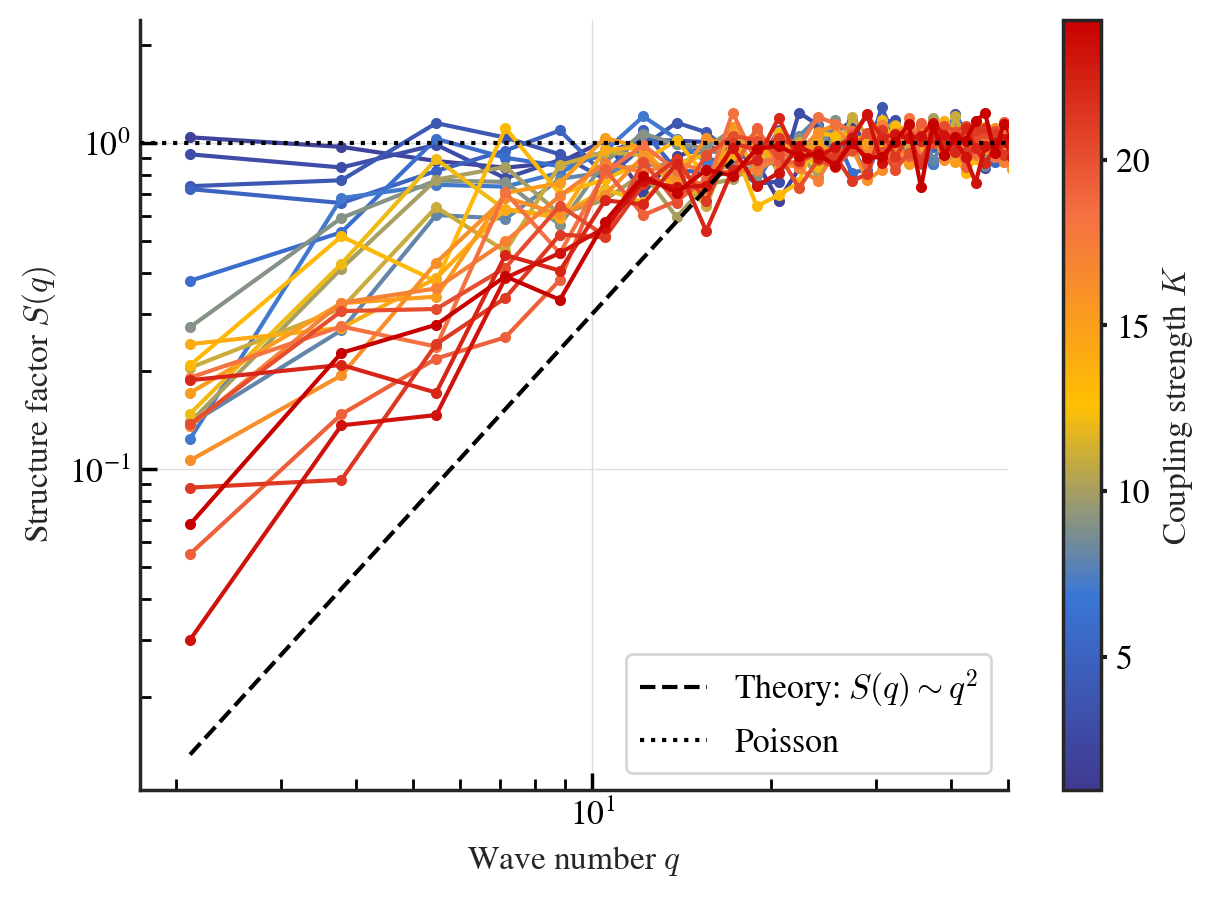

In [10]:
with open(f"temp/Sqs_dict_vary_K_d0_{distanceD0s[0]}.pkl", "rb") as f:
    Sqs_dict = pickle.load(f)

selectedKs = strengthKs[:-14]

fig, ax = plt.subplots(figsize=(7, 5))

for params, (qs, Sqs) in tqdm(Sqs_dict.items()):
    if params[0] not in selectedKs:
        continue

    qs, Sqs = np.array(qs), np.array(Sqs)
    # if params == (20, 0.25):
    #     plt.plot(qs, Sqs, marker='o', markersize=1, ls="", color="gray", alpha=0.2)
    
    q_bins = np.linspace(qs.min(), qs.max(), 60)
    Sqs_binned = np.zeros((len(q_bins)-1, 2))
    for i in range(len(q_bins)-1):
        mask = (qs >= q_bins[i]) & (qs < q_bins[i+1])
        if np.any(mask):
            Sqs_binned[i, 0] = np.mean(Sqs[mask])
            Sqs_binned[i, 1] = np.std(Sqs[mask]) / np.sqrt(np.sum(mask))

    plt.plot(
        0.5 * (q_bins[:-1] + q_bins[1:]), Sqs_binned[:, 0],
        marker="o", markersize=3, 
        color=cmap(params[0] / max(selectedKs))
    )

q_values = 0.5 * (q_bins[:-1] + q_bins[1:])[:10]
plt.plot(q_values, np.array(q_values) ** 2 * 0.003, '--', color="black", 
         markersize=2, linewidth=1.5, label=r'Theory: $S(q) \sim q^{2}$')

plt.axhline(1, color='black', linestyle=':', label="Poisson", zorder=100)
# plt.legend(loc="lower right", fontsize=12)
plt.xlabel('Wave number $q$', fontsize=12)
plt.ylabel('Structure factor $S(q)$', fontsize=12)
plt.semilogx()
plt.semilogy()
plt.xlim(None, 50)
plt.legend()
# plt.ylim(0.02, 5)
plt.grid()
ax.tick_params(which='both', direction="in")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

norm = plt.Normalize(min(selectedKs), max(selectedKs))
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar1 = plt.colorbar(sm, ax=ax)
cbar1.set_label(r'Coupling strength $K$', fontsize=12)
cbar1.ax.tick_params(length=2, direction="out", color="k", width=1.5)

# plt.savefig(f"{LOCAL_FIG_PATH}/Sq_vs_q_hyperuniformity_vary_K.pdf", bbox_inches='tight')

In [6]:
system_size = 7
num_particles = 5000

l_values = np.linspace(system_size / 50, 1.5, 40)  # 窗口大小 l
num_samples = 5000  # 每个l的随机采样次数 M

rho_0 = num_particles / (system_size**2)

In [ ]:
variance_rho_dict = dict()

np.random.seed(42)  # 设置随机种子以确保可重复性
for params, subPositions in tqdm(positions.items()):
    points = subPositions[-1]
    
    mean_density = []
    variance_rho = []

    for l in l_values:
        n_in_window = []
        
        for _ in range(num_samples):
            low_x = np.random.rand() * (system_size - l)
            low_y = np.random.rand() * (system_size - l)
            high_x = low_x + l
            high_y = low_y + l
            
            cond_x = (points[:, 0] >= low_x) & (points[:, 0] <= high_x)
            cond_y = (points[:, 1] >= low_y) & (points[:, 1] <= high_y)
            count = np.sum(cond_x & cond_y)
            
            n_in_window.append(count)
        
        n_in_window = np.array(n_in_window)
        
        variance_n = np.var(n_in_window)
        
        variance_rho.append(variance_n / (l**4))  # ⟨δρ²⟩ = ⟨δn²⟩ / l^4

    variance_rho_dict[params] = (l_values, np.array(variance_rho))

with open(f"temp/variance_rho_dict_vary_K_d0_{distanceD0s[0]}.pkl", "wb") as f:
    pickle.dump(variance_rho_dict, f)

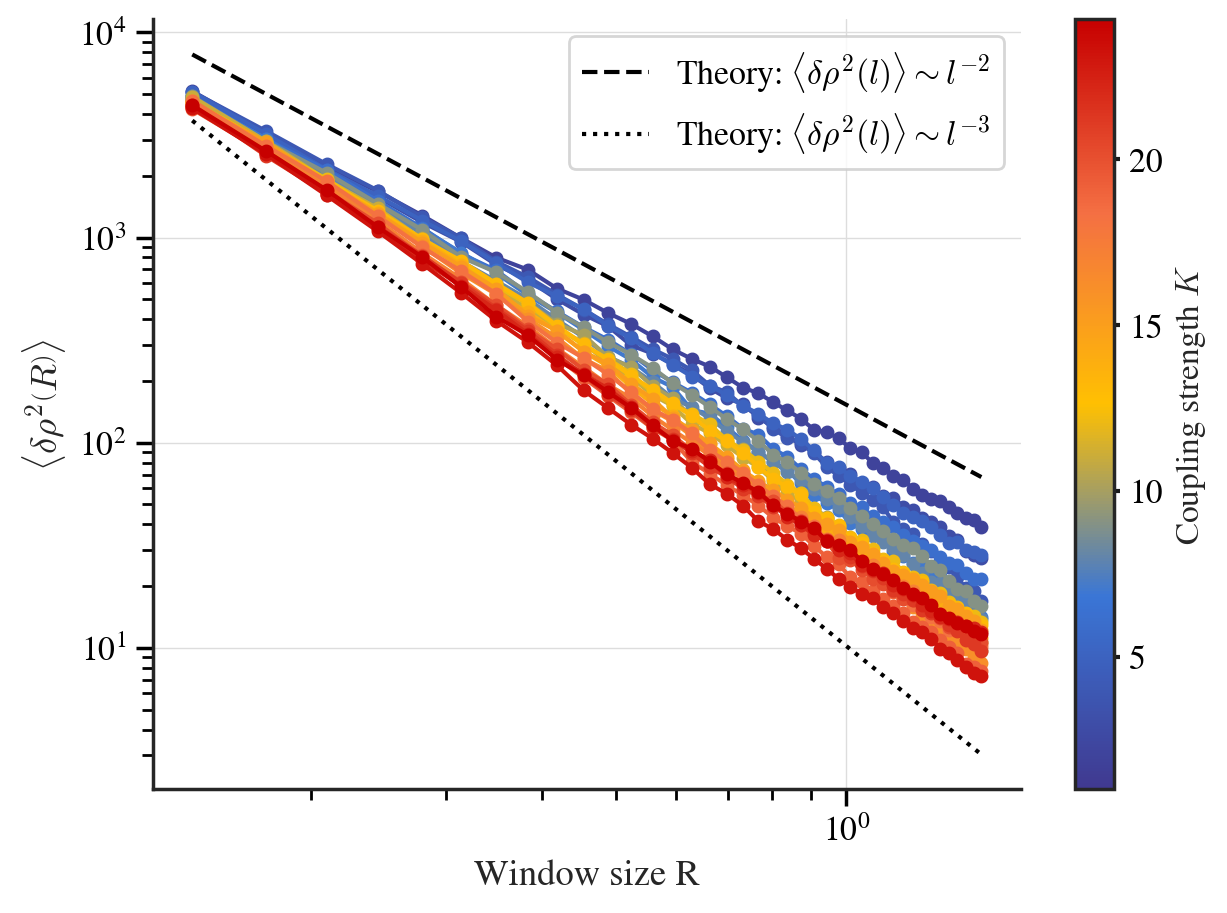

In [7]:
with open(f"temp/variance_rho_dict_vary_K_d0_{distanceD0s[0]}.pkl", "rb") as f:
    variance_rho_dict = pickle.load(f)

selectedKs = strengthKs[:-14]

fig, ax = plt.subplots(figsize=(7, 5))

for params, (l_values, variance_rho) in variance_rho_dict.items():
    if params[0] not in selectedKs:
        continue
    
    plt.loglog(l_values, variance_rho, 'o-', markersize=4,
               color=cmap(params[0] / max(selectedKs)))

plt.loglog(l_values, rho_0 / (l_values**2) * 1.5, '--', color="black", label=r'Theory: $\langle \delta \rho ^2( l ) \rangle \sim l^{-2}$')
plt.loglog(l_values, rho_0 / (l_values**3) / 10, ':', color="black", label=r'Theory: $\langle \delta \rho ^2( l ) \rangle \sim l^{-3}$')
# 理论线 ⟨δρ²(𝑙)⟩ = ρ₀ / l²

plt.xlabel('Window size R')
plt.ylabel(r'$\langle \delta \rho ^2\left( R \right) \rangle$')
# plt.legend()
plt.grid(True)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.legend()

norm = plt.Normalize(min(selectedKs), max(selectedKs))
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar1 = plt.colorbar(sm, ax=ax)
cbar1.set_label(r'Coupling strength $K$', fontsize=12)
cbar1.ax.tick_params(length=2, direction="out", color="k", width=1.5)

# plt.savefig("figs/density_fluctuation_variance_vary_K.pdf", bbox_inches='tight')

In [ ]:
from sklearn.linear_model import LinearRegression

with open(f"temp/variance_rho_dict_vary_K_d0_{distanceD0s[0]}.pkl", "rb") as f:
    variance_rho_dict = pickle.load(f)

selectedKs = strengthKs[:-15]

for params, (l_values, variance_rho) in variance_rho_dict.items():
    if params[0] not in selectedKs:
        continue
    
    

# Vary $d_0$

In [23]:
randomSeed = 10
phaseLags = [0.6 * np.pi]
strengthKs = [1]
distanceD0s = np.linspace(0.1, 3, 19)
omegaMins = [0]
deltaOmegas = [0]

models = [
    PhaseLagPatternFormation(
        strengthK=strengthK, distanceD0=distanceD0, phaseLagA0=phaseLag,
        boundaryLength=7, speedV=3,
        freqDist="uniform", initPhaseTheta=None,
        # initPhaseTheta=np.zeros(2000),
        omegaMin=omegaMin, deltaOmega=deltaOmega, 
        # agentsNum=2000,
        agentsNum=5000, 
        dt=0.005,
        tqdm=True, savePath=SAVE_PATH, shotsnaps=10, 
        randomSeed=randomSeed, overWrite=False
    )
    for strengthK in strengthKs
    for distanceD0 in distanceD0s
    for omegaMin in omegaMins
    for deltaOmega in deltaOmegas
    for phaseLag in phaseLags
]

lastStateSavePath = r"F:\MS_ExperimentData\hyperuniform"
savePath = (
    f"{lastStateSavePath}/{models[0].__class__.__name__}_"
    f"{models[0].freqDist}_"
    f"omegaMin{models[0].omegaMin:.3f}_deltaOmega{models[0].deltaOmega:.3f}_"
    f"phaseLagA0{models[0].phaseLagA0:.3f}_"
    f"Ks{strengthKs[0]:.3f}-{strengthKs[-1]:.3f}-{len(strengthKs)}_"
    f"D0s{distanceD0s[0]:.3f}-{distanceD0s[-1]:.3f}-{len(distanceD0s)}_"
    f"bL{models[0].boundaryLength}_"
    f"lastState.h5"
)
modelsNum = len(models)

sas = list()
allPositionX = pd.read_hdf(savePath, key="positionX")
allPhaseTheta = pd.read_hdf(savePath, key="phaseTheta")
allPositionX = allPositionX.values.reshape(modelsNum, models[0].agentsNum, 2)
allPhaseTheta = allPhaseTheta.values.reshape(modelsNum, models[0].agentsNum)

for i, model in enumerate(models):
    sa = StateAnalysis()
    sa.model = model
    sa.totalPositionX = np.array([allPositionX[i]])
    sa.totalPhaseTheta = np.array([allPhaseTheta[i]])
    sas.append(sa)


In [25]:
@nb.njit
def calculate_Sq_continuous(pos: np.ndarray, q_vec: np.ndarray, N: int):
    exp = np.exp(1j * np.dot(pos, q_vec))
    # return np.abs(np.sum(exp)) / N
    return np.abs(np.sum(exp)**2 / N)

positions = dict()
targetL = model.boundaryLength * 1
for sa in sas:
    model = sa.model
    positions[(model.strengthK, model.distanceD0)] = sa.totalPositionX[-1:] / model.boundaryLength * targetL
    # positions[(model.strengthK, model.distanceD0)] = sa.totalPositionX[-500:][::100] / model.boundaryLength * targetL

In [27]:
x = np.arange(1, 80) * 2 * np.pi / targetL
X, Y = np.meshgrid(x, x)
qVecs = np.column_stack((X.ravel(), Y.ravel())) # Wavevectors
q = np.linalg.norm(qVecs, axis=1)
qVecs = qVecs[np.argsort(q)]
q = np.sort(q)
qMin = 2 * np.pi * np.sqrt(2) / targetL

Sqs_dict = dict()
for params, subPositions in tqdm(positions.items()):
    
    Sqs = []
    qs = []

    for position in subPositions:
        for q_vec in qVecs:    
            Sq = calculate_Sq_continuous(position, q_vec, len(position))
            qs.append(np.linalg.norm(q_vec))
            Sqs.append(Sq)

    qs = np.array(qs)
    Sqs = np.array(Sqs)
    # qs, Sqs = qs[qs >= qMin], Sqs[qs >= qMin]
    Sqs_dict[params] = (qs, Sqs)

with open("Sqs_dict_vary_d0.pkl", "wb") as f:
    pickle.dump(Sqs_dict, f)

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

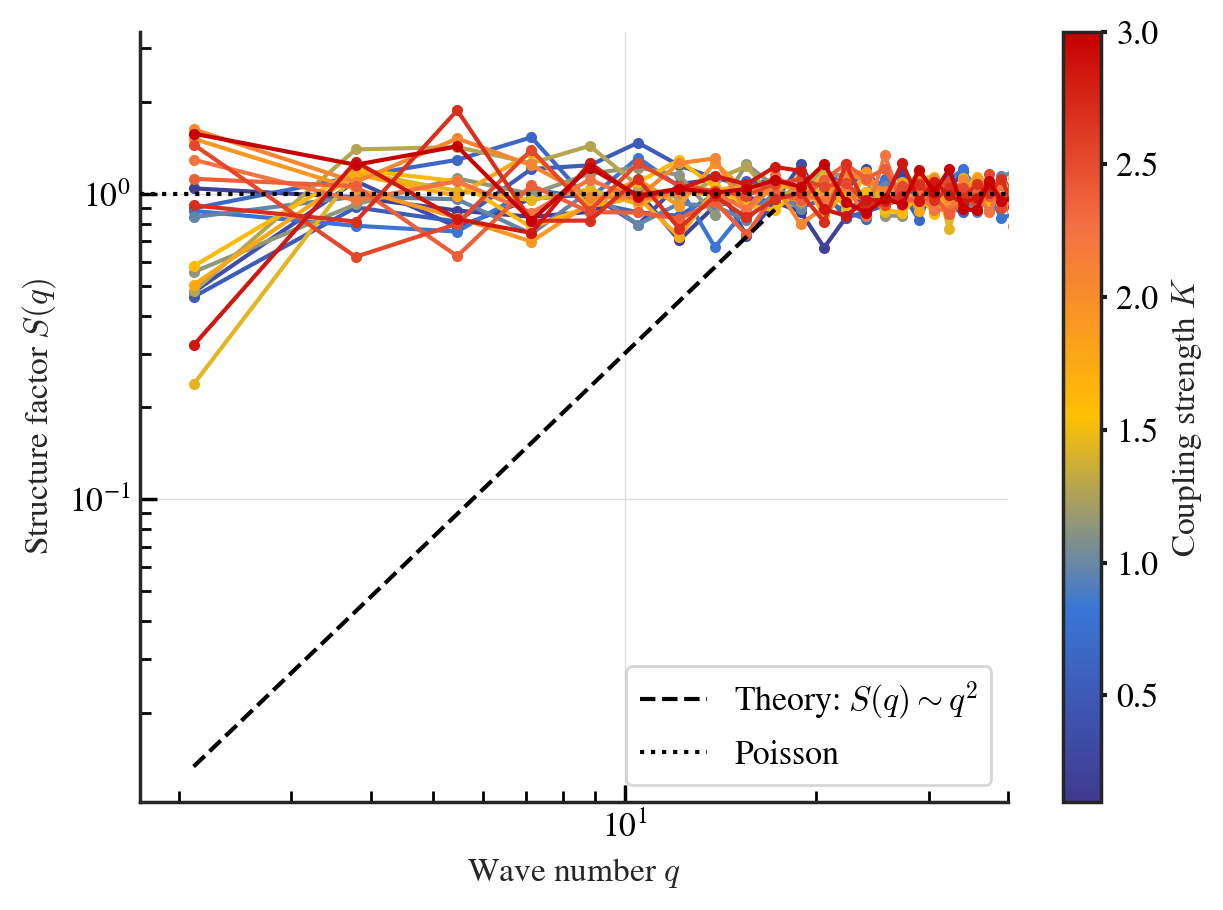

In [32]:
with open("Sqs_dict_vary_d0.pkl", "rb") as f:
    Sqs_dict = pickle.load(f)

fig, ax = plt.subplots(figsize=(7, 5))

for params, (qs, Sqs) in tqdm(Sqs_dict.items()):

    qs, Sqs = np.array(qs), np.array(Sqs)
    # if params == (20, 0.25):
    #     plt.plot(qs, Sqs, marker='o', markersize=1, ls="", color="gray", alpha=0.2)
    
    q_bins = np.linspace(qs.min(), qs.max(), 60)
    Sqs_binned = np.zeros((len(q_bins)-1, 2))
    for i in range(len(q_bins)-1):
        mask = (qs >= q_bins[i]) & (qs < q_bins[i+1])
        if np.any(mask):
            Sqs_binned[i, 0] = np.mean(Sqs[mask])
            Sqs_binned[i, 1] = np.std(Sqs[mask]) / np.sqrt(np.sum(mask))

    plt.plot(
        0.5 * (q_bins[:-1] + q_bins[1:]), Sqs_binned[:, 0],
        marker="o", markersize=3, 
        color=cmap(params[1] / max(distanceD0s))
    )

q_values = 0.5 * (q_bins[:-1] + q_bins[1:])[:10]
plt.plot(q_values, np.array(q_values) ** 2 * 0.003, '--', color="black", 
         markersize=2, linewidth=1.5, label=r'Theory: $S(q) \sim q^{2}$')

plt.axhline(1, color='black', linestyle=':', label="Poisson", zorder=100)
# plt.legend(loc="lower right", fontsize=12)
plt.xlabel('Wave number $q$', fontsize=12)
plt.ylabel('Structure factor $S(q)$', fontsize=12)
plt.semilogx()
plt.semilogy()
plt.xlim(None, 40)
plt.legend()
# plt.ylim(0.02, 5)
plt.grid()
ax.tick_params(which='both', direction="in")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

norm = plt.Normalize(min(distanceD0s), max(distanceD0s))
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar1 = plt.colorbar(sm, ax=ax)
cbar1.set_label(r'Coupling strength $K$', fontsize=12)
cbar1.ax.tick_params(length=2, direction="out", color="k", width=1.5)

plt.savefig(f"{LOCAL_FIG_PATH}/Sq_vs_q_hyperuniformity_vary_d0.pdf", bbox_inches='tight')

In [33]:
# 第 1 步：生成泊松随机点
system_size = 7
num_particles = 5000

l_values = np.linspace(system_size / 50, 1.5, 40)  # 窗口大小 l
num_samples = 5000  # 每个l的随机采样次数 M

rho_0 = num_particles / (system_size**2)

variance_rho_dict = dict()

np.random.seed(42)  # 设置随机种子以确保可重复性
for params, subPositions in tqdm(positions.items()):
    points = subPositions[-1]
    
    mean_density = []
    variance_rho = []

    for l in l_values:
        n_in_window = []
        
        for _ in range(num_samples):
            low_x = np.random.rand() * (system_size - l)
            low_y = np.random.rand() * (system_size - l)
            high_x = low_x + l
            high_y = low_y + l
            
            cond_x = (points[:, 0] >= low_x) & (points[:, 0] <= high_x)
            cond_y = (points[:, 1] >= low_y) & (points[:, 1] <= high_y)
            count = np.sum(cond_x & cond_y)
            
            n_in_window.append(count)
        
        n_in_window = np.array(n_in_window)
        
        variance_n = np.var(n_in_window)
        
        variance_rho.append(variance_n / (l**4))  # ⟨δρ²⟩ = ⟨δn²⟩ / l^4

    variance_rho_dict[params] = (l_values, np.array(variance_rho))

with open("variance_rho_dict_vary_d0.pkl", "wb") as f:
    pickle.dump(variance_rho_dict, f)

  0%|          | 0/19 [00:00<?, ?it/s]

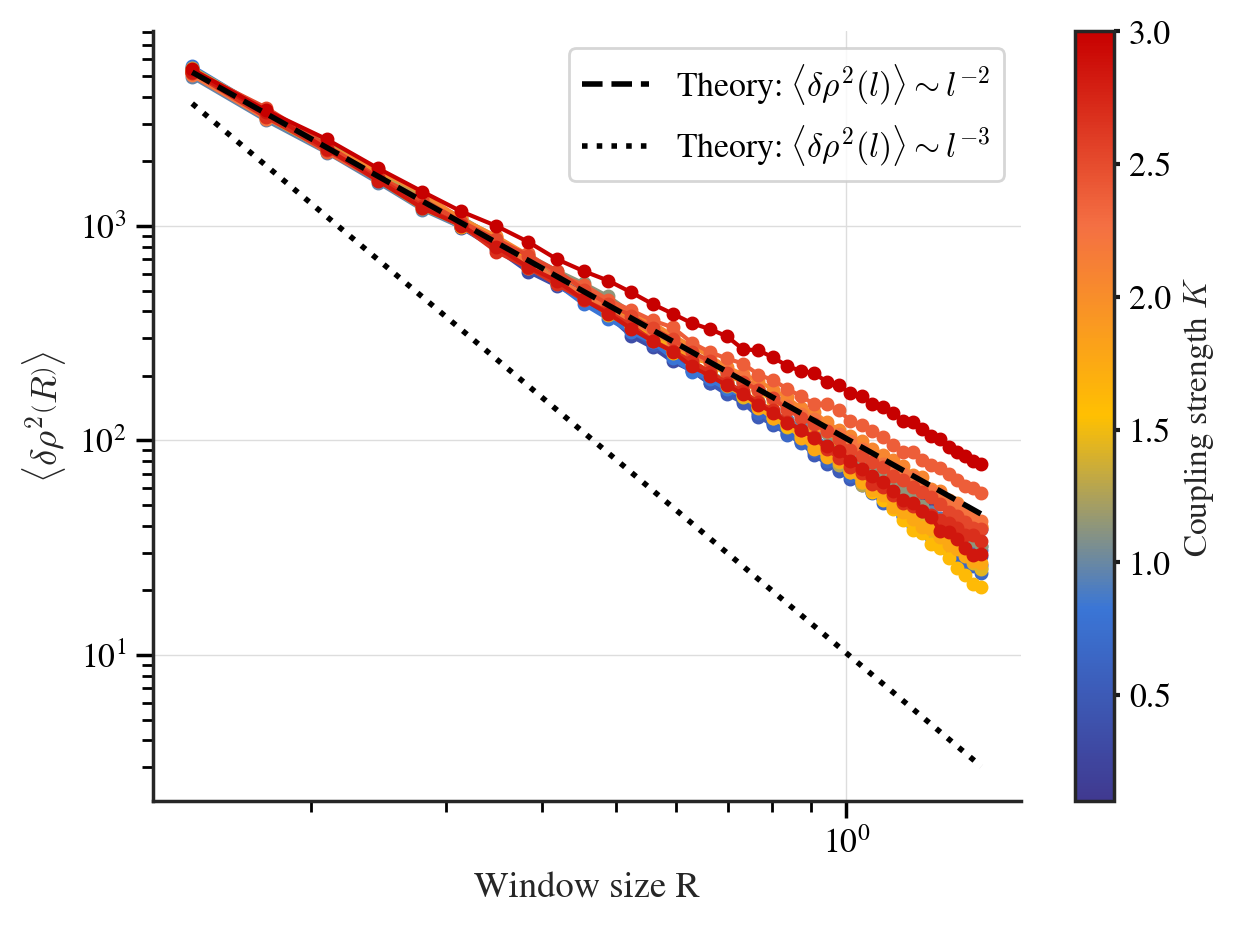

In [44]:
with open("variance_rho_dict_vary_d0.pkl", "rb") as f:
    variance_rho_dict = pickle.load(f)

fig, ax = plt.subplots(figsize=(7, 5))

for params, (l_values, variance_rho) in variance_rho_dict.items():

    plt.loglog(l_values, variance_rho, 'o-', markersize=4,
               color=cmap(params[1] / max(distanceD0s)))

plt.loglog(l_values, rho_0 / (l_values**2) * 1, '--', color="black", lw=2,
           label=r'Theory: $\langle \delta \rho ^2( l ) \rangle \sim l^{-2}$')
plt.loglog(l_values, rho_0 / (l_values**3) / 10, ':', color="black", lw=2,
           label=r'Theory: $\langle \delta \rho ^2( l ) \rangle \sim l^{-3}$')
# 理论线 ⟨δρ²(𝑙)⟩ = ρ₀ / l²

plt.xlabel('Window size R')
plt.ylabel(r'$\langle \delta \rho ^2\left( R \right) \rangle$')
# plt.legend()
plt.grid(True)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.legend()

norm = plt.Normalize(min(distanceD0s), max(distanceD0s))
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar1 = plt.colorbar(sm, ax=ax)
cbar1.set_label(r'Coupling strength $K$', fontsize=12)
cbar1.ax.tick_params(length=2, direction="out", color="k", width=1.5)

plt.savefig("figs/density_fluctuation_variance_vary_d0.pdf", bbox_inches='tight')